<a href="https://colab.research.google.com/github/aresmartius/cordic/blob/main/cordic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **CORDIC UNIFICADO**

In [1]:
# Versión 30-11-2025 - CORDIC UNIFICADO - Javier Martín Marcos

# Importamos librerias
from math import degrees, atan, atanh,ldexp


# Ángulos necesarios a ser precargados antes de generar iteraciones
def preload(v):
    # Calculamos los ángulos diádicos hasta el m pedido.
    beta = [degrees(atan(1 / 2 ** i)) for i in range(v)]
    return beta

def preload_h(v):
    # Igual que preload(v), pero los ángulos se calculan con atanh
    beta = [atanh(1 / 2 ** i) for i in range(1, v)]
    return beta


#ITERACIONES REQUERIDAS POR EL USUARIO
m = int(input('¿Cuántas iteraciones?: ')) + 1



class ITERATE:
    def __init__(self, theta):
        '''
        En esta sección vamos a configurar los parámetros de la iteración
        según el modo correspondiente.
        Va a ser configurado como una superfunción de Python (def __init__),
        para facilitar la lectura de variables en las distintas funciones
        del programa.
        '''
        self.LN2 = 0.69314718056 #ln(2)
        self.cosine_alpha = 0.607252935 if mode != 3 else 1.20753406 #Factor P y J respectivamente
        self.sine_alpha = theta * self.cosine_alpha if mode == 2  else 0
        self.hyperbolic_reducing_factor = round(theta/self.LN2)
        self.theta_remaining = self.normalize(theta) if mode != 3 else theta - (self.hyperbolic_reducing_factor)*self.LN2
        self.beta = preload(m) if mode != 3 else preload_h(m + 1)
        self.alpha = 0
        self.hyperbolic_related = 1
        '''
        self.hyperbolic_related no es más que un indicador para saber si restar
        o sumar en self.cosine_alpha en la iteración dependiendo de si es una
        función hiperbólica o trigonométrica

        self.hyperbolic_reducing_factor nos sirve para reducir el valor theta que requerimos , pues la suma
        de todos los valores beta convergen en 1.055, el cual no es suficiente para valores muy altos
        '''
        print(self.theta_remaining)

    # Normalizamos los ángulos para que se encuentren en el primer cuadrante (solo presente en las trigonométricas)
    def normalize(self, theta):
        global inversion, sine_sign, cosine_sign
        cosine_sign = 1
        sine_sign = 1
        normalize_theta = theta // 360
        theta -= normalize_theta * 360
        inversion = 0
        if theta > 270:
            theta -= 270
            sine_sign = -1
            inversion += 1
        elif theta > 180:
            theta -= 180
            sine_sign = -1
            cosine_sign = -1
        elif theta > 90:
            theta -= 90
            cosine_sign = -1
            inversion += 1
        return theta

    def step(self, m):
        global mode
        old_cos = self.cosine_alpha
        old_sin = self.sine_alpha
        if mode == 2:
            D = 1 if old_cos * old_sin < 0 else -1
        elif mode == 3:
            D = 1 if self.theta_remaining >= 0 else -1
            self.hyperbolic_related = -1

        else:
            D = 1 if self.theta_remaining >= 0 else -1

        '''
        E hace referencia a los racionales diádicos tienen diferente valor en el exponente, simplemente
        porque cuando nos encontramos en el modo hiperbólicos los valores son válidos a partir de m >=1,
        mientras que en el resto a partir de m >= 0, por facilidad de la unificación esta es la forma más
        sencilla de implementarlo
        '''
        E = (1 / (2 ** (m - 1))) if mode !=3 else (1 / (2 ** m))

        # Esto es la esencia del algoritmo iterativo de CORDIC
        self.cosine_alpha = (old_cos - self.hyperbolic_related * D * E * old_sin) # C_m
        self.sine_alpha = (old_sin + D * E * old_cos) # S_m
        self.theta_remaining -= D * self.beta[m - 1] # Diferencia entre el ángulo que llevamos y el idílico
        self.alpha += D * self.beta[m - 1] # "Ángulo que llevamos"

        if mode == 1:
            '''
            Cuando el ángulo va pasando por los distintos cuadrantes se invierten los valores de
            seno y coseno, por lo que debemos de arreglarlo en el caso de que sea asi, devolviendolos
            a su valor correspondiente
            '''
            if inversion != 0:
                print(
                    f"Iteración {m}: D={D}, cos(α)={self.sine_alpha * cosine_sign}, sin(α)={self.cosine_alpha * sine_sign}, θ_m={abs(self.theta_remaining)}, α= {self.alpha}")
            else:
                print(
                    f"Iteración {m}: D={D}, cos(α)={self.cosine_alpha * cosine_sign}, sin(α)={self.sine_alpha * sine_sign}, θ_m={abs(self.theta_remaining)}, α={self.alpha}")
        elif mode == 2:
            print(f"Iteración {m}: D={D}, α= {abs(self.alpha)}")
        elif mode == 3:
            print(
                f"Iteración {m}: D={D}, cosh(α)={self.cosine_alpha}, sinh(α)={self.sine_alpha},  α= {self.alpha}, θ_m={self.theta_remaining}")

    def hyperbolic_refactoring(self):
        #Tenemos que reconstruir el ángulo que hemos reducido
        exp_reduced_theta = self.cosine_alpha + self.sine_alpha #e^x

        # Aplicamos el factor de escala 2^k
        # math.ldexp(x, k) es equivalente a x * (2**k) (Desplazamiento de bits)
        exp_theta = ldexp(exp_reduced_theta, self.hyperbolic_reducing_factor)

        '''
        cosh(t) = (e^t + e^-t) / 2
        sinh(t) = (e^t - e^-t) / 2

        Siguiendo las propiedades hiperbólicas calculamos el inverso
        '''
        inverse_exp_theta = 1 / exp_theta

        self.cosine_alpha = (exp_theta + inverse_exp_theta) * (1/2)
        self.sine_alpha = (exp_theta - inverse_exp_theta) * (1/2)
        print('-'*55)
        print(f'Este es el resultado del CORDIC hiperbólico tras haberle aplicado el factor de aumento: senh(Ψ)= {self.sine_alpha} , cosh(Ψ)= {self.cosine_alpha}')



print('Seleccione que desea calcular con CORDIC: ')
print('1: Seno y coseno # Modo rotación de CORDIC')
print('2: Arcotangente # Modo vectorial de CORDIC')
print('3: Funciones hiperbólicas')
mode = int(input('Introduce modo: '))

if mode == 1:
    t = ITERATE(float(input('θ : ')))
elif mode == 2:
    t = ITERATE(float(input('Ψ : ')))
elif mode == 3:
    t = ITERATE(float(input('Ψ : ')))
else:
    print('Error al seleccionar modo, intentelo de nuevo')

if mode != 3:
    for j in range(1, m):
        t.step(j)
else:
    '''
    En el modo hiperbólico necesitamos repetir la iteración (3*k+1), para
    no perder precisión (si no lo implementaramos perderiamos una precisión de alrededor
    de 0.5
    '''
    def hyperbolic_repeat_indices(max_iter):
        repeats = [] # Indicador de m que se debe repetir en la iteración de CORDIC
        k = 4
        while k < max_iter:
            repeats.append(k)
            k = 3 * k + 1
        return repeats

    repeat_indices = hyperbolic_repeat_indices(m)
    iter_sequence = []
    for k in range(1, m):
        iter_sequence.append(k)
        if k in repeat_indices:
            iter_sequence.append(k)  # Añade la iteración repetida

    for j in iter_sequence:
        t.step(j)

    # Refactorización hiperbólica
    t.hyperbolic_refactoring()

KeyboardInterrupt: Interrupted by user

# **CORDIC** **TRIGONOMÉTRICO**
---



In [ ]:
# Versión 25-08-2025
from math import degrees, atan, cos, radians


def preload(v):
    beta = [degrees(atan(1 / 2 ** i)) for i in range(v)]
    cosine_beta = [cos(radians(b)) for b in beta]
    return cosine_beta, beta


v = int(input('¿Cuántas iteraciones quieres para aproximar al ángulo theta?: '))+1


class ITERATE:
    def __init__(self, theta):
        self.cosine_alpha = 0.607252935 #Inicializado con el factor P
        self.sine_alpha = 0
        self.theta_remaining = self.normalize(theta)
        print(self.theta_remaining)
        self.cosine_beta, self.beta = preload(v)
        self.alpha = 0

    def normalize(self, theta):
        global inversion, sine_sign, cosine_sign
        cosine_sign = 1
        sine_sign = 1
        normalize_theta = theta // 360
        theta -= normalize_theta * 360
        inversion = 0
        if theta > 270:
            theta -= 270
            sine_sign = -1
            inversion += 1
        elif theta > 180:
            theta -= 180
            sine_sign = -1
            cosine_sign = -1
        elif theta > 90:
            theta -= 90
            cosine_sign = -1
            inversion += 1
        return theta

    def step(self, m):
        old_cos = self.cosine_alpha
        old_sin = self.sine_alpha
        D = 1 if self.theta_remaining >= 0 else -1
        self.cosine_alpha = (old_cos - D * (1 / (2 ** (m-1))) * old_sin)
        self.sine_alpha = (old_sin + D * (1 / (2 ** (m-1))) * old_cos)
        self.theta_remaining -= D * self.beta[m-1]
        self.alpha += D*self.beta[m-1]

        if inversion != 0:
            print(
                f"Iteración {m}: D={D}, cos(α)={self.sine_alpha * cosine_sign}, sin(α)={self.cosine_alpha * sine_sign}, θ_m={abs(self.theta_remaining)}, α= {self.alpha}")
        else:
            print(
                f"Iteración {m}: D={D}, cos(α)={self.cosine_alpha * cosine_sign}, sin(α)={self.sine_alpha * sine_sign}, θ_m={abs(self.theta_remaining)}, α={self.alpha}")


# Ejemplo
t = ITERATE(float(input('θ : ')))
for j in range(1,v):
    t.step(j)


¿Cuántas iteraciones quieres para aproximar al ángulo theta?: 12
θ : 2
2.0
Iteración 1: D=1, cos(α)=0.607252935, sin(α)=0.607252935, θ_m=43.0, α=45.0
Iteración 2: D=-1, cos(α)=0.9108794025, sin(α)=0.3036264675, θ_m=16.43494882292201, α=18.43494882292201
Iteración 3: D=-1, cos(α)=0.986786019375, sin(α)=0.075906616875, θ_m=2.3987053549955313, α=4.398705354995531
Iteración 4: D=-1, cos(α)=0.996274346484375, sin(α)=-0.047441635546875, θ_m=4.726310993906266, α=-2.7263109939062664
Iteración 5: D=1, cos(α)=0.9992394487060546, sin(α)=0.014825511108398436, θ_m=1.1499766189089153, α=0.8500233810910847
Iteración 6: D=1, cos(α)=0.9987761514839172, sin(α)=0.04605174388046264, θ_m=0.6399339893371541, α=2.639933989337154
Iteración 7: D=-1, cos(α)=0.9994957099820494, sin(α)=0.03044586651352643, θ_m=0.25523972087392033, α=1.7447602791260797
Iteración 8: D=1, cos(α)=0.9992578516499124, sin(α)=0.038254426747761194, θ_m=0.19237444998663278, α=2.192374449986633
Iteración 9: D=-1, cos(α)=0.9994072830043959,



> CORDIC SIN CONSTANTE P Y CON IDENTIDADES TRIGONOMÉTRICAS CLÁSICAS




In [ ]:
# Versión 03-08-2025 - Se ha implementado CORDIC en su totalidad
# Se han conseguido normalizar los ángulos, pero cuando CORDIC no funciona entre 0 y num_max_pos se invierten el coseno y el seno


# Precargamos en el programa los distintos arctan(1/2^n)
num_max_pos = 99.882965
A = [
    45.0,
    26.56505117707799,
    14.036243467926479,
    7.125016348901798,
    3.576334374997351,
    1.7899106082460694,
    0.8951737102110744,
    0.4476141708605531,
    0.22381050036853808,
    0.1119056770662069,
    0.055952891893803675,
    0.027976452617003676,
    0.013988227142265016,
    0.006994113675352919,
    0.003497056850704011,
    0.00174852842698097,
    0.00087426409535751,
    0.00043713205086107,
    0.00021856602783438,
    0.00010928301330234,
    0.00005464150665244,
    0.00002732075332622,
    0.00001366037666311,
    0.00000683018833155,
    0.00000341509416578,
    0.00000170754708289,
    0.00000085377354145,
    0.00000042688677072,
    0.00000021344338536,
    0.00000010672169268,
    0.00000005336084634
]
T = [0]
# T_[n+1] se genera utilizando A[n]+T[n], siendo el primer valor de T = 0
"""
cosacosb + senasenb = cos(a-b)
senacosb + senbcosa = sen(a+b)
Conocemos que A_0 = 45 y que T_1 = 45 porque T[n+1] = T[n]+A[n] donde T[0] = 0
sen(A_0) = sen(T_1)
cos(A_0) = cos(T_1)
Sabemos que sen(45) = sqr(2)/2 y cos(45) por lo que podríamos sacar T_2 fácilmente haciendo (sqr(2)/2 )**2 * 2
"""
# También precalculamos el coseno y el seno del ángulo A
Cosinus = [
    0.7071067811865476,
    0.8944271909999159,
    0.9701425001453319,
    0.9922778767136676,
    0.9980525784828885,
    0.9995120760870788,
    0.9998779520346953,
    0.9999694838187878,
    0.9999923706927791,
    0.9999980926568242,
    0.9999995231631829,
    0.9999998807907318,
    0.999999970197679,
    0.9999999925494195,
    0.9999999981373549,
    0.9999999995343387,
    0.9999999998835846,
    0.9999999999708962,
    0.9999999999927241,
    0.999999999998181,
    0.9999999999995453,
    0.9999999999998863,
    0.9999999999999716,
    0.999999999999993,
    0.9999999999999982,
    0.9999999999999996,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0
]
Sinus = [
    0.7071067811865476,
    0.447213595499958,
    0.24253562503633294,
    0.12403473458920845,
    0.062378286155180526,
    0.031234752377721213,
    0.015623093000542114,
    0.007812261592334281,
    0.0039062201980186685,
    0.0019531212747203597,
    0.0009765620343390458,
    0.0004882811917923495,
    0.0002441406177240427,
    0.00012207031159050533,
    6.1035156136313156e-05,
    3.051757812603283e-05,
    1.5258789061315762e-05,
    7.62939453110197e-06,
    3.814697265606496e-06,
    1.907348632810187e-06,
    9.5367431640625e-07,
    4.76837158203125e-07,
    2.384185791015625e-07,
    1.1920928955078125e-07,
    5.960464477539063e-08,
    2.9802322387695312e-08,
    1.4901161193847656e-08,
    7.450580596923828e-09,
    3.725290298461914e-09,
    1.862645149230957e-09,
    9.313225746154785e-10
]
Sinus_T = [0]
Sinus_SIGN = 1
Cosinus_SIGN = 1
Cosinus_T = [1]
A_sum = 0
# Empezamos con la recursión, para esto primero necesitamos un ángulo inicial
reach = float(input('Número del que se desea el seno y coseno: '))
normalize_reach = reach // 360
reach -= normalize_reach*360
inversion = 0
# Por comodidad vamos a normalizar con 90º y derivados y no con el máximo de CORDIC
if reach > 270:
    reach -= 270
    Sinus_SIGN = -1
    inversion +=1

elif reach > 180:
    reach -= 180
    Sinus_SIGN = -1
    Cosinus_SIGN = -1
elif reach > 90:
    reach -= 90
    Cosinus_SIGN = -1
    inversion += 1
for j, i in enumerate(A):
    # Determinamos si sumamos o restamos ángulos dependiendo de si es mayor o menor del deseado
    if A_sum < reach:
        Cosinus_T_new = Cosinus_T[j] * Cosinus[j] - Sinus_T[j] * Sinus[j]
        Sinus_T_new = Sinus_T[j] * Cosinus[j] + Cosinus_T[j] * Sinus[j]
        T_new = T[j] + A[j]
        A_sum += A[j]
    else: # A_sum >= reach
        Cosinus_T_new = Cosinus_T[j] * Cosinus[j] + Sinus_T[j] * Sinus[j]
        Sinus_T_new = Sinus_T[j] * Cosinus[j] - Cosinus_T[j] * Sinus[j]
        T_new = T[j] - A[j]
        A_sum -= A[j]

    Sinus_T.append(Sinus_T_new)
    Cosinus_T.append(Cosinus_T_new)
    T.append(T_new)

if inversion != 0:
    Sinus_T,Cosinus_T = Cosinus_T,Sinus_T


print(T[-1])
print(f'Aproximación al número {reach} este es su seno: {Sinus_T[-1]*Sinus_SIGN:.10f} y este es su coseno: {Cosinus_T[-1]*Cosinus_SIGN:.10f}')


Número del que se desea el seno y coseno: 120
30.00000002373757
Aproximación al número 30.0 este es su seno: 0.8660254036 y este es su coseno: -0.5000000004


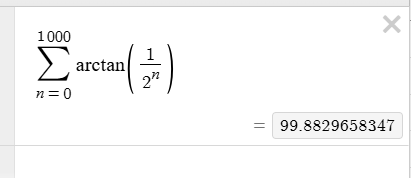

INVERSIÓN DEL SENO Y COSENO EN LOS CUADRANTES PARES

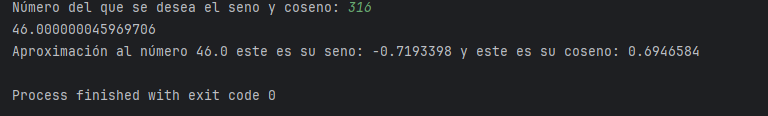